## Siemens Data Cleaning, Data Wrangling and EDA

**Index**

1. Loading the datasets
2. Transposing the time series datasets
3. Merging time series datasets to add additional features and delete unmatching testID
4. Sensor B - Filtering by type of fluid to compute calibration/sample windows
5. Window extraction
6. Displaying time series from the window extraction
7. EDA on time series from the window extraction
8. Visualising the time series from the Cal/Sample windows

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, entropy
import skfda

### 1. Loading the datasets

In [2]:
# import datasets
sensorA_System1 = pd.read_csv("System1_SensorA.csv")
sensorA_System2 = pd.read_csv("System2_SensorA.csv")
sensorB_System1 = pd.read_csv("System1_SensorB.csv")
sensorB_System2 = pd.read_csv("System2_SensorB.csv")
keyByTestID = pd.read_csv("Key by TestID.csv")

## 2. Transposing the time series datasets

In [3]:
# Transpose dataset to make columns as timestamps and rows as tests

# Sensor A
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

# Sensor B
B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

## 3. Merging time series datasets to add additional features and delete unmatching testID

In [4]:
# Merge dataset with keyByTestID and delete unmatched tests for sensor A

# Sensor A
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]

# Verifying the filter on Sensor A
print(A1_Merged[['System', 'Sensor']].value_counts())
print(A2_Merged[['System', 'Sensor']].value_counts())

# Sensor B
B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B2_transposed = B2_transposed[B2_transposed['TestID'].isin(B2_Merged['TestID'])]

# Verifying the filter on Sensor B
print(B1_Merged[['System', 'Sensor']].value_counts())
print(B2_Merged[['System', 'Sensor']].value_counts())

System    Sensor  
System 1  Sensor A    3407
dtype: int64
System     Sensor  
System 2A  Sensor A    5365
System 2B  Sensor A    2416
dtype: int64
System    Sensor  
System 1  Sensor B    3398
dtype: int64
System     Sensor  
System 2A  Sensor B    5365
System 2B  Sensor B    2415
dtype: int64


### 4. Sensor B - Filtering by type of fluid to compute calibration/sample windows

In [5]:
# Sensor B - Filtering by type of fluid to compute calibration/sample windows accordingly 

# Blood
B1_blood_Merged = (B1_Merged[B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_blood_Merged = (B2_Merged[B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_blood_Merged.reset_index(drop=True, inplace=True)
B2_blood_Merged.reset_index(drop=True, inplace=True)

# Aquous
B1_aquous_Merged = (B1_Merged[~B1_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B2_aquous_Merged = (B2_Merged[~B2_Merged['FluidType'].isin(['Eurotrol L1', 'Eurotrol L3', 'Eurotrol L4', 'Eurotrol L5'])]).copy()
B1_aquous_Merged.reset_index(drop=True, inplace=True)
B2_aquous_Merged.reset_index(drop=True, inplace=True)

### 5. Window extraction

In [6]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Match window values of Sensor B for each test

# Blood
calDelLimit_sensorB_blood = 20
sampleDelLimit_sensorB_blood = 24
calWindowSize_sensorB_blood = 18
sampleWindowSize_sensorB_blood = 4

# Aquous
calDelLimit_sensorB_aqueous = 20
sampleDelLimit_sensorB_aqueous = 30
calWindowSize_sensorB_aqueous = 18
sampleWindowSize_sensorB_aqueous = 4

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit_input, cal_window_size_input, sampleDelimit_input, sample_window_size_input):
    cal_window_start = bubble_start - calDelimit_input
    cal_window_end = cal_window_start + cal_window_size_input
    sample_window_start = sample_start + sampleDelimit_input
    sample_window_end = sample_window_start + sample_window_size_input
    return cal_window_start, cal_window_end, sample_window_start, sample_window_end

# Sensor A
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size, 
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelimit,
                                                                                                   cal_window_size_input=cal_window_size, 
                                                                                                   sampleDelimit_input=sampleDelimit,
                                                                                                   sample_window_size_input=sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end


# Sensor B - Blood
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood, 
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B1_blood_Merged['cal_window_start']=cal_window_start
B1_blood_Merged['cal_window_end']=cal_window_end
B1_blood_Merged['sample_window_start']=sample_window_start
B1_blood_Merged['sample_window_end']=sample_window_end

cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_blood_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_blood_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_blood,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_blood, 
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_blood,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_blood)
B2_blood_Merged['cal_window_start']=cal_window_start
B2_blood_Merged['cal_window_end']=cal_window_end
B2_blood_Merged['sample_window_start']=sample_window_start
B2_blood_Merged['sample_window_end']=sample_window_end


# Sensor B - Aquous
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B1_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B1_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous, 
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B1_aquous_Merged['cal_window_start']=cal_window_start
B1_aquous_Merged['cal_window_end']=cal_window_end
B1_aquous_Merged['sample_window_start']=sample_window_start
B1_aquous_Merged['sample_window_end']=sample_window_end


cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=B2_aquous_Merged['BubbleDetectTime'],
                                                                                                   sample_start=B2_aquous_Merged['SampleDetectTime'],
                                                                                                   calDelimit_input=calDelLimit_sensorB_aqueous,
                                                                                                   cal_window_size_input=calWindowSize_sensorB_aqueous, 
                                                                                                   sampleDelimit_input=sampleDelLimit_sensorB_aqueous,
                                                                                                   sample_window_size_input=sampleWindowSize_sensorB_aqueous)
B2_aquous_Merged['cal_window_start']=cal_window_start
B2_aquous_Merged['cal_window_end']=cal_window_end
B2_aquous_Merged['sample_window_start']=sample_window_start
B2_aquous_Merged['sample_window_end']=sample_window_end


In [7]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# Sensor A
A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)

A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)


# System 1 - Sensor B - Blood

B1_blood_cal_window = []
B1_blood_sample_window = []
for i in range(len(B1_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B1_blood_Merged.iloc[i, :])
    B1_blood_cal_window.append(cal_window.values)
    B1_blood_sample_window.append(sample_window.values)
B1_blood_cal_window = pd.DataFrame(B1_blood_cal_window)
B1_blood_sample_window = pd.DataFrame(B1_blood_sample_window)
B1_blood_cal_window['TestID'] = B1_blood_sample_window['TestID'] = B1_blood_Merged['TestID']
B1_blood_sample_window.set_index('TestID',inplace=True)
B1_blood_cal_window.set_index('TestID',inplace=True)

B2_blood_cal_window = []
B2_blood_sample_window = []
for i in range(len(B2_blood_Merged)):
    cal_window, sample_window = calculate_window_data(B2_blood_Merged.iloc[i, :])
    B2_blood_cal_window.append(cal_window.values)
    B2_blood_sample_window.append(sample_window.values)
B2_blood_cal_window = pd.DataFrame(B2_blood_cal_window)
B2_blood_sample_window = pd.DataFrame(B2_blood_sample_window)
B2_blood_cal_window['TestID'] = B2_blood_sample_window['TestID'] = B2_blood_Merged['TestID']
B2_blood_sample_window.set_index('TestID',inplace=True)
B2_blood_cal_window.set_index('TestID',inplace=True)

# System 1 - Sensor B - Aquous

B1_aquous_cal_window = []
B1_aquous_sample_window = []
for i in range(len(B1_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B1_aquous_Merged.iloc[i, :])
    B1_aquous_cal_window.append(cal_window.values)
    B1_aquous_sample_window.append(sample_window.values)
B1_aquous_cal_window = pd.DataFrame(B1_aquous_cal_window)
B1_aquous_sample_window = pd.DataFrame(B1_aquous_sample_window)
B1_aquous_cal_window['TestID'] = B1_aquous_sample_window['TestID'] = B1_aquous_Merged['TestID']
B1_aquous_sample_window.set_index('TestID',inplace=True)
B1_aquous_cal_window.set_index('TestID',inplace=True)

B2_aquous_cal_window = []
B2_aquous_sample_window = []
for i in range(len(B2_aquous_Merged)):
    cal_window, sample_window = calculate_window_data(B2_aquous_Merged.iloc[i, :])
    B2_aquous_cal_window.append(cal_window.values)
    B2_aquous_sample_window.append(sample_window.values)
B2_aquous_cal_window = pd.DataFrame(B2_aquous_cal_window)
B2_aquous_sample_window = pd.DataFrame(B2_aquous_sample_window)
B2_aquous_cal_window['TestID'] = B2_aquous_sample_window['TestID'] = B2_aquous_Merged['TestID']
B2_aquous_sample_window.set_index('TestID',inplace=True)
B2_aquous_cal_window.set_index('TestID',inplace=True)

### 6. Display time series from the window extraction

In [8]:
# Display A1/A2
display(A1_cal_window, A1_sample_window,A2_cal_window, A2_sample_window)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
TestID,,,,,,,,,,,,,,,,,,,,,
12414199,47.481120,47.501380,47.496910,47.488570,47.486480,47.510920,47.504660,47.494830,47.482320,47.498700,...,47.515390,47.509130,47.507640,47.508830,47.491850,47.526420,47.506750,47.533870,47.528210,47.531480
12414200,56.742800,56.760980,56.740120,56.767830,56.745190,56.762170,56.727310,56.738630,56.746380,56.729090,...,56.724030,56.705250,56.737140,56.715390,56.732970,56.730290,56.716280,56.722240,56.732370,56.720450
12414201,43.908820,43.919550,43.932070,43.958600,43.952050,43.959500,43.981250,43.966050,43.970830,44.006590,...,44.173530,44.191410,44.184260,44.200050,44.196780,44.209000,44.223310,44.218240,44.247750,44.236130
12414202,59.229880,59.265350,59.251940,59.266240,59.273700,59.251050,59.250150,59.269520,59.286810,59.276080,...,59.293370,59.286810,59.279660,59.287700,59.271610,59.273990,59.294260,59.290980,59.287410,59.279060
12414203,56.880650,56.860690,56.881550,56.877670,56.870820,56.881840,56.868730,56.894070,56.878570,56.875590,...,56.950680,56.922970,56.925350,56.952470,56.926250,56.935190,56.932800,56.922070,56.928330,56.938470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12537663,8.024467,8.056956,8.093321,8.120445,8.155618,8.197049,8.230433,8.270078,8.304058,8.329393,...,9.089771,9.131800,9.150578,9.185453,9.228077,9.238808,9.272788,9.315709,9.366084,9.394997
12539049,-19.179190,-19.159810,-19.125540,-19.111240,-19.089780,-19.059380,-19.042990,-18.995310,-18.980700,-18.949110,...,-18.482410,-18.452600,-18.434130,-18.412070,-18.381380,-18.374520,-18.331010,-18.349190,-18.298230,-18.284520
12572832,-100.171800,-100.189900,-100.166700,-100.161600,-100.170600,-100.160100,-100.156300,-100.162500,-100.139000,-100.154200,...,-100.114300,-100.112800,-100.110700,-100.126200,-100.119900,-100.109500,-100.105600,-100.117800,-100.123800,-100.136000


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
TestID,,,,,,,,,,,,,,,,,,,,,
12414199,40.856900,40.855110,40.838120,40.866430,40.850340,40.849140,40.832760,40.821140,40.82322,40.811600,...,40.78239,40.787760,40.785370,40.803850,40.785070,40.775540,40.78776,40.788650,40.789540,40.808320
12414200,50.105190,50.078970,50.063180,50.069430,50.072110,50.053940,50.025630,50.032780,50.02056,50.022950,...,50.02116,49.989860,49.987480,49.982410,49.983010,49.969300,49.98569,49.960960,49.970200,49.946060
12414201,38.259330,38.232500,38.249790,38.254860,38.238160,38.248000,38.266180,38.259920,38.24710,38.262910,...,38.28288,38.272450,38.307320,38.285260,38.310000,38.306720,38.30851,38.296290,38.310900,38.317460
12414202,52.856190,52.833830,52.828770,52.852910,52.830260,52.842180,52.822810,52.814460,52.81655,52.798960,...,52.76975,52.760210,52.766770,52.767670,52.757530,52.763790,52.78644,52.738450,52.732490,52.747400
12414203,50.507980,50.490390,50.500530,50.510060,50.468940,50.480560,50.481160,50.470730,50.46894,50.458510,...,50.43348,50.431690,50.426620,50.427220,50.439740,50.411420,50.41500,50.439140,50.435860,50.415890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12537663,25.852390,25.858940,25.881600,25.906640,25.885470,25.921240,25.943300,25.942700,25.94747,25.954330,...,26.04375,26.069680,26.091740,26.124520,26.112600,26.137340,26.14569,26.163270,26.178480,26.188310
12539049,-14.990170,-14.954110,-14.975270,-14.946660,-14.935630,-14.932060,-14.914470,-14.909110,-14.90434,-14.890330,...,-14.81404,-14.819400,-14.798240,-14.766650,-14.761880,-14.763080,-14.75294,-14.733870,-14.699600,-14.713010
12572832,-85.030100,-85.019070,-85.036060,-85.040530,-85.062880,-85.060500,-85.063180,-85.078980,-85.07928,-85.095960,...,-85.14663,-85.146330,-85.166000,-85.158840,-85.164510,-85.162720,-85.17822,-85.171360,-85.178820,-85.187450


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
TestID,,,,,,,,,,,,,,,,,,,,,
3550995,27.48563,27.49427,27.51215,27.54821,27.56162,27.58040,27.59977,27.62451,27.63881,27.66563,...,28.13085,28.14426,28.16303,28.19045,28.20774,28.22473,28.25095,28.26883,28.27688,28.30281
3551012,15.45354,15.46874,15.50062,15.51940,15.54831,15.57453,15.59450,15.61298,15.63980,15.66036,...,16.17892,16.19472,16.21856,16.24866,16.26684,16.29128,16.30857,16.33181,16.36280,16.37473
3551031,40.42490,40.45411,40.46603,40.49017,40.52891,40.55961,40.58077,40.60729,40.63531,40.66362,...,41.25549,41.28768,41.31122,41.33298,41.35474,41.38513,41.41225,41.44980,41.46918,41.49719
3551047,28.34900,28.35794,28.37076,28.41188,28.42947,28.44318,28.46821,28.48162,28.50904,28.52424,...,28.97604,28.99303,29.00704,29.03744,29.06068,29.07201,29.09793,29.12029,29.14472,29.13936
3551065,25.88137,25.89716,25.92995,25.94753,25.97644,25.99760,26.02144,26.04886,26.06734,26.08581,...,26.59007,26.61600,26.64103,26.65444,26.68186,26.70063,26.73312,26.74921,26.77037,26.79690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3518675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3518676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
TestID,,,,,,,,,,,,,,,,,,,,,
3550995,34.94455,34.96810,34.99045,35.01250,35.02532,35.04320,35.05870,35.07330,35.09744,35.11830,...,35.21426,35.24198,35.24109,35.26433,35.27268,35.27983,35.29175,35.31202,35.33377,35.33377
3551012,23.20780,23.23492,23.25698,23.25966,23.28767,23.31330,23.33238,23.34459,23.36158,23.37142,...,23.50046,23.51894,23.53712,23.54636,23.55679,23.57795,23.58570,23.61192,23.62623,23.63964
3551031,48.81813,48.83839,48.86105,48.88816,48.92363,48.94926,48.96267,48.99188,49.00737,49.03062,...,49.19513,49.20348,49.23119,49.25861,49.27440,49.28811,49.31255,49.32835,49.34235,49.36828
3551047,35.81329,35.84130,35.85501,35.87915,35.89674,35.91372,35.93131,35.95187,35.96349,35.97363,...,36.09612,36.11340,36.11519,36.13605,36.15065,36.16347,36.17837,36.19357,36.20042,36.22277
3551065,33.67706,33.69405,33.72117,33.74382,33.76974,33.78435,33.80551,33.82667,33.84187,33.85528,...,33.98790,34.00340,34.02008,34.03141,34.04363,34.07164,34.07850,34.09608,34.10920,34.13959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3518675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3518676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# B1/B2 - Blood
display(B1_blood_cal_window, B1_blood_sample_window,B2_blood_cal_window, B2_blood_sample_window)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
TestID,,,,,,,,,,,,,,,,,,,,,
12414199,-259.1879,-259.1330,-259.0687,-259.0198,-258.9966,-258.9057,-258.8634,-258.7987,-258.7629,-258.6759,...,-254.7432,-254.6660,-254.6470,-254.5728,-254.5215,-254.4670,-254.4333,-254.3466,-254.3117,-254.2676
12414200,-258.3153,-258.2846,-258.2232,-258.1987,-258.1323,-258.0843,-258.0459,-257.9949,-257.9288,-257.8927,...,-254.3246,-254.2552,-254.2015,-254.1956,-254.1130,-254.0776,-253.9971,-253.9825,-253.9428,-253.8683
12414201,-259.2193,-259.1623,-259.1021,-259.0452,-259.0038,-258.9513,-258.8869,-258.8419,-258.8023,-258.7379,...,-255.0665,-255.0120,-254.9673,-254.9225,-254.8489,-254.8006,-254.7514,-254.7047,-254.6593,-254.6268
12414202,-257.3784,-257.3135,-257.2583,-257.1972,-257.1501,-257.1111,-257.0351,-257.0124,-256.9641,-256.9030,...,-253.3189,-253.2828,-253.2313,-253.2023,-253.1523,-253.1129,-253.0545,-252.9922,-252.9716,-252.9156
12414203,-255.4571,-255.4109,-255.3519,-255.3007,-255.2420,-255.2128,-255.1487,-255.1111,-255.0700,-254.9845,...,-251.5424,-251.4870,-251.4253,-251.3830,-251.3371,-251.2939,-251.2400,-251.2030,-251.1765,-251.1074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12537664,-261.7110,-261.6675,-261.6210,-261.5573,-261.5292,-261.4875,-261.4351,-261.3892,-261.3552,-261.3078,...,-258.1726,-258.1297,-258.0859,-258.0525,-257.9917,-257.9476,-257.8978,-257.8606,-257.8221,-257.7971
12537668,-269.2318,-269.2024,-269.1398,-269.1290,-269.0775,-269.0530,-269.0119,-268.9824,-268.9266,-268.8837,...,-266.2635,-266.2120,-266.1825,-266.1455,-266.1205,-266.1071,-266.0576,-266.0367,-265.9863,-265.9544
12624891,-299.5483,-299.5170,-299.4931,-299.4633,-299.4422,-299.4076,-299.3915,-299.3561,-299.3489,-299.3096,...,-297.2080,-297.1833,-297.1704,-297.1582,-297.1129,-297.0855,-297.0530,-297.0155,-296.9860,-296.9577


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
TestID,,,,,,,,,,,,,,,,,,,,,
12414199,-252.4275,-252.3801,-252.3089,-252.2555,-252.1715,-252.1280,-252.1015,-252.0117,-251.9724,-251.9435,...,-251.8204,-251.7504,-251.6845,-251.6416,-251.5880,-251.5320,-251.4810,-251.4396,-251.3672,-251.3305
12414200,-252.4281,-252.3732,-252.3085,-252.2472,-252.1944,-252.1181,-252.0597,-252.0320,-251.9551,-251.9033,...,-251.7635,-251.7399,-251.6961,-251.6112,-251.5587,-251.5158,-251.4434,-251.3966,-251.3362,-251.2941
12414201,-252.7366,-252.6743,-252.6138,-252.5595,-252.5104,-252.4752,-252.4060,-252.3485,-252.2966,-252.2558,...,-252.1375,-252.0996,-252.0465,-251.9977,-251.9544,-251.8963,-251.8349,-251.7872,-251.7362,-251.6733
12414202,-251.6614,-251.5955,-251.5547,-251.4927,-251.4325,-251.3723,-251.3097,-251.2593,-251.1955,-251.1410,...,-251.0471,-250.9955,-250.9353,-250.8882,-250.8325,-250.7857,-250.7288,-250.6694,-250.6331,-250.5764
12414203,-249.9779,-249.9460,-249.8637,-249.8221,-249.7943,-249.7347,-249.6817,-249.6161,-249.5696,-249.5127,...,-249.4203,-249.3440,-249.3178,-249.2552,-249.2108,-249.1763,-249.1041,-249.0737,-249.0168,-248.9641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12537664,-226.8337,-226.7586,-226.6870,-226.5988,-226.5458,-226.4737,-226.3988,-226.3264,-226.2424,-226.1917,...,-226.0540,-225.9935,-225.9375,-225.8499,-225.7962,-225.7381,-225.6761,-225.6246,-225.5513,-225.4985
12537668,-235.5786,-235.4686,-235.4007,-235.3240,-235.2519,-235.2027,-235.1071,-235.0275,-234.9777,-234.9017,...,-234.7785,-234.7091,-234.6301,-234.5645,-234.5109,-234.4322,-234.3866,-234.3192,-234.2679,-234.2027
12624891,-318.4741,-318.5164,-318.5715,-318.5936,-318.5984,-318.6294,-318.6890,-318.7259,-318.7619,-318.7917,...,-318.8409,-318.8564,-318.8871,-318.9342,-318.9327,-318.9557,-318.9944,-318.9962,-319.0400,-319.0418


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
TestID,,,,,,,,,,,,,,,,,,,,,
3550995,-294.0569,-294.0078,-293.9601,-293.9184,-293.8746,-293.8221,-293.7670,-293.7229,-293.6743,-293.6361,...,-290.3212,-290.2753,-290.2262,-290.1844,-290.1487,-290.0980,-290.0575,-290.0161,-289.9630,-289.9249
3551012,-304.1492,-304.0956,-304.0485,-304.0127,-303.9686,-303.9290,-303.8700,-303.8381,-303.7961,-303.7591,...,-300.7831,-300.7446,-300.6987,-300.6614,-300.6278,-300.5944,-300.5533,-300.5035,-300.4668,-300.4278
3551031,-271.9737,-271.9269,-271.8885,-271.8358,-271.7863,-271.7410,-271.6996,-271.6578,-271.6337,-271.5884,...,-268.5685,-268.5238,-268.4797,-268.4392,-268.4010,-268.3772,-268.3221,-268.2872,-268.2490,-268.2118
3551047,-285.5681,-285.5165,-285.4572,-285.4023,-285.3648,-285.3156,-285.2626,-285.2122,-285.1541,-285.1106,...,-281.6628,-281.6127,-281.5757,-281.5263,-281.4893,-281.4312,-281.3948,-281.3585,-281.3218,-281.2711
3551065,-294.4435,-294.3961,-294.3520,-294.2993,-294.2551,-294.1949,-294.1502,-294.0984,-294.0549,-294.0078,...,-290.6726,-290.6357,-290.5969,-290.5516,-290.4991,-290.4607,-290.4115,-290.3722,-290.3400,-290.2899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518442,-242.3768,-242.3541,-242.3380,-242.3151,-242.2927,-242.2781,-242.2766,-242.2513,-242.2385,-242.2146,...,-240.9799,-240.9647,-240.9409,-240.9322,-240.9135,-240.8968,-240.8789,-240.8741,-240.8536,-240.8306
3518443,-269.0380,-269.0189,-269.0058,-268.9939,-268.9879,-268.9659,-268.9518,-268.9253,-268.9200,-268.9095,...,-267.8235,-267.8086,-267.7961,-267.7863,-267.7690,-267.7517,-267.7413,-267.7311,-267.7219,-267.6992
3518444,-259.3616,-259.3545,-259.3426,-259.3306,-259.3101,-259.2964,-259.2800,-259.2675,-259.2555,-259.2513,...,-258.2685,-258.2524,-258.2375,-258.2312,-258.2074,-258.1940,-258.1874,-258.1734,-258.1656,-258.1531


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
TestID,,,,,,,,,,,,,,,,,,,,,
3550995,-268.4115,-268.3298,-268.2440,-268.1528,-268.0818,-267.9901,-267.9153,-267.8360,-267.7466,-267.6706,...,-267.5230,-267.4423,-267.3752,-267.2936,-267.2325,-267.1466,-267.0748,-267.0182,-266.9395,-266.8772
3551012,-279.5596,-279.4732,-279.3921,-279.3030,-279.2264,-279.1653,-279.0831,-279.0139,-278.9355,-278.8733,...,-278.7207,-278.6518,-278.5866,-278.5106,-278.4459,-278.3768,-278.3034,-278.2471,-278.1851,-278.1136
3551031,-247.9110,-247.8192,-247.7567,-247.6702,-247.5859,-247.5102,-247.4363,-247.3642,-247.2798,-247.2137,...,-247.0679,-247.0042,-246.9234,-246.8533,-246.7774,-246.7046,-246.6406,-246.5818,-246.5115,-246.4388
3551047,-260.1425,-260.0591,-259.9676,-259.8871,-259.8093,-259.7244,-259.6377,-259.5751,-259.4916,-259.4255,...,-259.2732,-259.1978,-259.1197,-259.0529,-258.9778,-258.9039,-258.8354,-258.7627,-258.7069,-258.6256
3551065,-268.8633,-268.7706,-268.6967,-268.6013,-268.5211,-268.4487,-268.3718,-268.2851,-268.2204,-268.1421,...,-267.9904,-267.9158,-267.8524,-267.7677,-267.6971,-267.6354,-267.5612,-267.4959,-267.4259,-267.3481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518442,-266.2308,-266.2934,-266.3602,-266.4064,-266.4657,-266.5360,-266.6007,-266.6635,-266.7255,-266.7759,...,-266.8960,-266.9518,-267.0090,-267.0641,-267.1169,-267.1800,-267.2235,-267.2840,-267.3424,-267.3895
3518443,-293.2223,-293.2839,-293.3468,-293.4100,-293.4684,-293.5426,-293.5939,-293.6493,-293.7018,-293.7670,...,-293.8788,-293.9405,-293.9950,-294.0484,-294.1151,-294.1527,-294.2081,-294.2567,-294.3091,-294.3726
3518444,-283.6159,-283.6815,-283.7361,-283.7939,-283.8693,-283.9208,-283.9804,-284.0409,-284.1002,-284.1560,...,-284.2791,-284.3288,-284.3851,-284.4358,-284.4868,-284.5493,-284.6137,-284.6647,-284.7076,-284.7642


In [10]:
# B1/B2 - Aquous
display(B1_aquous_cal_window, B1_aquous_sample_window,B2_aquous_cal_window, B2_aquous_sample_window)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
TestID,,,,,,,,,,,,,,,,,,,,,
12414372,-252.1506,-252.0931,-252.0678,-251.9843,-251.9745,-251.9220,-251.8589,-251.8446,-251.7739,-251.7072,...,-248.3125,-248.2631,-248.2118,-248.1844,-248.1197,-248.0858,-248.0151,-248.0017,-247.9314,-247.8938
12414373,-251.8584,-251.8057,-251.7857,-251.7255,-251.6712,-251.6441,-251.5788,-251.5407,-251.4924,-251.4363,...,-248.0345,-247.9975,-247.9277,-247.8926,-247.8309,-247.8079,-247.7399,-247.6860,-247.6621,-247.6064
12414374,-248.3406,-248.2992,-248.2592,-248.1981,-248.1412,-248.1010,-248.0446,-248.0044,-247.9552,-247.9046,...,-244.3532,-244.3287,-244.2593,-244.2027,-244.1830,-244.1463,-244.0703,-244.0373,-243.9869,-243.9231
12414375,-248.6014,-248.5683,-248.5162,-248.4491,-248.4089,-248.3493,-248.2944,-248.2506,-248.2092,-248.1508,...,-244.6441,-244.6289,-244.5654,-244.5228,-244.4519,-244.4215,-244.3944,-244.3204,-244.2722,-244.2349
12414377,-252.6598,-252.6127,-252.5713,-252.5131,-252.4702,-252.4351,-252.3811,-252.3334,-252.2816,-252.2395,...,-248.8951,-248.8510,-248.8123,-248.7431,-248.7160,-248.6671,-248.6284,-248.5700,-248.5387,-248.4904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470355,-302.6591,-302.6361,-302.6099,-302.5694,-302.5509,-302.5306,-302.4951,-302.4811,-302.4269,-302.4266,...,-300.6218,-300.6230,-300.5834,-300.6007,-300.5390,-300.5068,-300.5140,-300.4875,-300.4511,-300.4484
12470361,-284.2341,-284.1855,-284.1537,-284.1200,-284.0726,-284.0541,-284.0246,-283.9826,-283.9465,-283.9153,...,-281.6211,-281.5910,-281.5737,-281.5397,-281.5075,-281.4810,-281.4497,-281.4184,-281.3886,-281.3591
12470365,-277.4145,-277.3907,-277.3603,-277.3347,-277.2542,-277.2622,-277.2199,-277.1782,-277.1281,-277.1054,...,-274.6692,-274.6143,-274.5756,-274.5655,-274.5318,-274.5124,-274.4501,-274.4406,-274.4170,-274.3789


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
TestID,,,,,,,,,,,,,,,,,,,,,
12414372,-232.1234,-232.0742,-232.0146,-231.9759,-231.9148,-231.8721,-231.8483,-231.7684,-231.7479,-231.6954,...,-231.5861,-231.5601,-231.5101,-231.4734,-231.4019,-231.3804,-231.3318,-231.2907,-231.2335,-231.1852
12414373,-232.2787,-232.2357,-232.1824,-232.1558,-232.0885,-231.9919,-231.9582,-231.9382,-231.8923,-231.8437,...,-231.7546,-231.7069,-231.6732,-231.6345,-231.5758,-231.5352,-231.5006,-231.4520,-231.3960,-231.3578
12414374,-228.3007,-228.2474,-228.2107,-228.1556,-228.1121,-228.0656,-228.0265,-227.9738,-227.9124,-227.8846,...,-227.7973,-227.7487,-227.7094,-227.6543,-227.6000,-227.5631,-227.5219,-227.4662,-227.4239,-227.3682
12414375,-228.5765,-228.5479,-228.5011,-228.4513,-228.4171,-228.3670,-228.2955,-228.2696,-228.2103,-228.1662,...,-228.0851,-228.0431,-227.9847,-227.9412,-227.9006,-227.8675,-227.8184,-227.7802,-227.7510,-227.6908
12414377,-233.2275,-233.2021,-233.1208,-233.0850,-233.0513,-233.0177,-232.9643,-232.8967,-232.8841,-232.8156,...,-232.7417,-232.6976,-232.6606,-232.6213,-232.5641,-232.5277,-232.4767,-232.4401,-232.3912,-232.3659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12470355,-288.6573,-288.6346,-288.6153,-288.6057,-288.5581,-288.5372,-288.5164,-288.4958,-288.4588,-288.4585,...,-288.4028,-288.3554,-288.3581,-288.3298,-288.3208,-288.2794,-288.2603,-288.2368,-288.2303,-288.1682
12470361,-268.9327,-268.8955,-268.8573,-268.8314,-268.8079,-268.7778,-268.7414,-268.7047,-268.6815,-268.6636,...,-268.5939,-268.5674,-268.5286,-268.5030,-268.4797,-268.4625,-268.4094,-268.3835,-268.3638,-268.3397
12470365,-262.2839,-262.2552,-262.2376,-262.1965,-262.1712,-262.1450,-262.1122,-262.0877,-262.0570,-262.0394,...,-261.9902,-261.9407,-261.9121,-261.8916,-261.8734,-261.8490,-261.8302,-261.7860,-261.7589,-261.7375


,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
TestID,,,,,,,,,,,,,,,,,,,,,
3545083,-248.5291,-248.4737,-248.4173,-248.3473,-248.3059,-248.2328,-248.1732,-248.1142,-248.0615,-248.0099,...,-243.9825,-243.9404,-243.9029,-243.8451,-243.7902,-243.7324,-243.6814,-243.6353,-243.5602,-243.5157
3545084,-249.6118,-249.5390,-249.4902,-249.4237,-249.3745,-249.3224,-249.2601,-249.2053,-249.1463,-249.0863,...,-245.1823,-245.1280,-245.0788,-245.0174,-244.9781,-244.9334,-244.8765,-244.8178,-244.7704,-244.7167
3545085,-257.1921,-257.1346,-257.0884,-257.0300,-256.9612,-256.8983,-256.8631,-256.8065,-256.7538,-256.6965,...,-253.0207,-252.9712,-252.9125,-252.8884,-252.8297,-252.7948,-252.7486,-252.7003,-252.6485,-252.5978
3545086,-248.3490,-248.2858,-248.2221,-248.1562,-248.0969,-248.0412,-247.9848,-247.9172,-247.8552,-247.8022,...,-243.7198,-243.6772,-243.6152,-243.5544,-243.5115,-243.4701,-243.4123,-243.3637,-243.2996,-243.2487
3545087,-257.6692,-257.6135,-257.5449,-257.4892,-257.4391,-257.3733,-257.3229,-257.2624,-257.2037,-257.1402,...,-253.1691,-253.1184,-253.0609,-253.0135,-252.9554,-252.9184,-252.8728,-252.8079,-252.7500,-252.7095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518583,-242.8030,-242.7777,-242.7583,-242.7422,-242.7324,-242.7204,-242.7014,-242.6897,-242.6754,-242.6564,...,-241.5936,-241.5719,-241.5632,-241.5617,-241.5373,-241.5355,-241.5137,-241.4982,-241.4890,-241.4717
3518675,-240.2716,-240.2626,-240.2418,-240.2209,-240.2135,-240.1899,-240.1807,-240.1577,-240.1375,-240.1297,...,-238.9761,-238.9585,-238.9355,-238.9281,-238.9004,-238.8911,-238.8652,-238.8500,-238.8375,-238.8223
3518676,-259.1026,-259.0842,-259.0690,-259.0532,-259.0275,-259.0126,-258.9870,-258.9724,-258.9533,-258.9420,...,-257.6477,-257.6435,-257.6128,-257.6086,-257.5869,-257.5642,-257.5467,-257.5267,-257.5130,-257.4903


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
TestID,,,,,,,,,,,,,,,,,,,,,
3545083,-226.4068,-226.3630,-226.3115,-226.2694,-226.2167,-226.1547,-226.1082,-226.0605,-226.0164,-225.9607,...,-225.8781,-225.8293,-225.7726,-225.7264,-225.6817,-225.6346,-225.5795,-225.5354,-225.4868,-225.4508
3545084,-227.9976,-227.9362,-227.8969,-227.8513,-227.7950,-227.7494,-227.6927,-227.6397,-227.6007,-227.5497,...,-227.4460,-227.3992,-227.3578,-227.3006,-227.2514,-227.2043,-227.1679,-227.1107,-227.0621,-227.0174
3545085,-236.2837,-236.2390,-236.1919,-236.1508,-236.1019,-236.0667,-236.0161,-235.9666,-235.9288,-235.8775,...,-235.7920,-235.7532,-235.7020,-235.6650,-235.6218,-235.5810,-235.5366,-235.4987,-235.4528,-235.4096
3545086,-226.5448,-226.5075,-226.4515,-226.4062,-226.3513,-226.3010,-226.2518,-226.2068,-226.1609,-226.1099,...,-226.0170,-225.9612,-225.9186,-225.8682,-225.8238,-225.7720,-225.7338,-225.6838,-225.6346,-225.5878
3545087,-235.7359,-235.6799,-235.6244,-235.5750,-235.5294,-235.4718,-235.4191,-235.3786,-235.3279,-235.2728,...,-235.1783,-235.1270,-235.0823,-235.0278,-234.9920,-234.9512,-234.8979,-234.8436,-234.8058,-234.7602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3518583,-230.0151,-229.9972,-229.9847,-229.9484,-229.9302,-229.9102,-229.8968,-229.8774,-229.8548,-229.8452,...,-229.8020,-229.7791,-229.7651,-229.7496,-229.7251,-229.7129,-229.6998,-229.6810,-229.6658,-229.6450
3518675,-232.1996,-232.1844,-232.1576,-232.1329,-232.1221,-232.1004,-232.0810,-232.0736,-232.0527,-232.0226,...,-231.9928,-231.9833,-231.9541,-231.9395,-231.9195,-231.9046,-231.8799,-231.8739,-231.8560,-231.8331
3518676,-250.3777,-250.3563,-250.3411,-250.3163,-250.2972,-250.2812,-250.2597,-250.2442,-250.2227,-250.2016,...,-250.1661,-250.1500,-250.1268,-250.1092,-250.0889,-250.0666,-250.0406,-250.0397,-250.0213,-250.0091


### 7. EDA on time series from the window extraction

In [11]:
# Function to extract basic statistcs from the whole time-series
def extract_time_domain_features(df):
    features = []
    for i, row in df.iterrows():
        values = row.values[1:]
        values = np.nan_to_num(values)  # Replace NaN with 0
        feature = {
            'mean': np.mean(values),
            'median': np.median(values),
            'std': np.std(values),
            'var': np.var(values),
            'skew': skew(values),
            'kurtosis': kurtosis(values),
            'entropy': entropy(np.histogram(values)[0]) # Measure of randomness in the dataset
        }
        features.append(feature)
    return pd.DataFrame(features)

In [12]:
missing_values_index_A2_cal_window = A2_cal_window[A2_cal_window.isna().any(axis=1)].index
print("System 2 - Sensor A - Cal Window:\n")
print("Total TestID with missing values:", len(missing_values_index_A2_cal_window))
print(missing_values_index_A2_cal_window)

System 2 - Sensor A - Cal Window:

Total TestID with missing values: 190
Int64Index([3556267, 3556175, 3556176, 3556177, 3556178, 3556179, 3556180,
            3556181, 3556416, 3556417,
            ...
            3518443, 3518444, 3518445, 3518456, 3518579, 3518583, 3518675,
            3518676, 3518677, 3518678],
           dtype='int64', name='TestID', length=190)


In [13]:
# --- Sensor A --- 
print("EDA Sensor A\n")

# Shape of the series
print("Shape time-series\n")
print("Shape System 1 - Sensor A - Cal Window: ", A1_cal_window.shape)
print("Shape System 2 - Sensor A - Cal Window: ", A2_cal_window.shape)
print("Shape System 1 - Sensor A - Sample Window: ", A1_sample_window.shape)
print("Shape System 2 - Sensor A - Sample Window: ", A2_sample_window.shape, "\n")

# Check for missing values per column (partial missing values)
print("\nCheck for missing values\n")
print("System 1 - Sensor A - Cal Window:\n", A1_cal_window.isna().sum())
print("\nSystem 2 - Sensor A - Cal Window:\n", A2_cal_window.isna().sum())
print("\nSystem 1 - Sensor A - Sample Window:\n", A1_sample_window.isna().sum())
print("\nShape System 2 - Sensor A - Sample Window:\n", A2_sample_window.isna().sum())

# Check for TestID with missing values
print("\nTestID with missing values\n")
missing_values_index_A1_cal_window = A1_cal_window[A1_cal_window.isna().any(axis=1)].index
print("\nSystem 1 - Sensor A - Cal Window:\n")
print("Total TestID with missing values:", len(missing_values_index_A1_cal_window))
print(missing_values_index_A1_cal_window)

missing_values_index_A2_cal_window = A2_cal_window[A2_cal_window.isna().any(axis=1)].index
print("\nSystem 2 - Sensor A - Cal Window:\n")
print("Total TestID with missing values:", len(missing_values_index_A2_cal_window))
print(missing_values_index_A2_cal_window)

missing_values_index_A1_sample_window = A1_sample_window[A1_sample_window.isna().any(axis=1)].index
print("\nSystem 1 - Sensor A - Sample Window:\n")
print("Total TestID with missing values:", len(missing_values_index_A1_sample_window))
print(missing_values_index_A1_sample_window)

missing_values_index_A2_sample_window = A2_sample_window[A2_sample_window.isna().any(axis=1)].index
print("\nSystem 2 - Sensor A - Sample Window:\n")
print("Total TestID with missing values:", len(missing_values_index_A2_sample_window))
print(missing_values_index_A2_sample_window)

# Statistical measurements on the time whole time series
A1_calWindow_features_df = extract_time_domain_features(A1_cal_window)
print("\nSystem 1 - Sensor A - Cal Window:\n ")
print(A1_calWindow_features_df.describe())
A2_calWindow_features_df = extract_time_domain_features(A2_cal_window)
print("\nSystem 2 - Sensor A - Cal Window:\n ")
print(A2_calWindow_features_df.describe())
A1_sampleWindow_features_df = extract_time_domain_features(A1_sample_window)
print("\nSystem 1 - Sensor A - Sample Window:\n ")
print(A1_sampleWindow_features_df.describe())
A2_sampleWindow_features_df = extract_time_domain_features(A2_sample_window)
print("\nSystem 2 - Sensor A - Sample Window:\n ")
print(A2_sampleWindow_features_df.describe())


# --- Sensor B - Blood --- 

print("\nEDA Sensor B - Blood\n")

# Shape of the series
print("Shape time-series\n")
print("Shape System 1 - Sensor B - Blood - Cal Window: ", B1_blood_cal_window.shape)
print("Shape System 2 - Sensor B - Blood - Cal Window: ", B2_blood_cal_window.shape)
print("Shape System 1 - Sensor B - Blood - Sample Window: ", B1_blood_sample_window.shape)
print("Shape System 2 - Sensor B - Blood - Sample Window: ", B2_blood_sample_window.shape, "\n")

# Check for missing values per column (partial missing values)
print("\nCheck for missing values\n")
print("System 1 - Sensor B - Blood - Cal Window:\n", B1_blood_cal_window.isna().sum())
print("\nSystem 2 - Sensor B - Blood - Cal Window:\n", B2_blood_cal_window.isna().sum())
print("\nSystem 1 - Sensor B - Blood - Sample Window:\n", B1_blood_sample_window.isna().sum())
print("\nShape System 2 - Sensor B - Blood - Sample Window:\n", B2_blood_sample_window.isna().sum())

# Check for TestID with missing values
print("\nTestID with missing values\n")
missing_values_index_B1_blood_cal_window = B1_blood_cal_window[B1_blood_cal_window.isna().any(axis=1)].index
print("\nSystem 1 - Sensor B - Blood - Cal Window:\n")
print("Total TestID with missing values:", len(missing_values_index_B1_blood_cal_window))
print(missing_values_index_B1_blood_cal_window)

missing_values_index_B2_blood_cal_window = B2_blood_cal_window[B2_blood_cal_window.isna().any(axis=1)].index
print("\nSystem 2 - Sensor B - Blood - Cal Window:\n")
print("Total TestID with missing values:", len(missing_values_index_B2_blood_cal_window))
print(missing_values_index_B2_blood_cal_window)

missing_values_index_B1_blood_sample_window = B1_blood_sample_window[B1_blood_sample_window.isna().any(axis=1)].index
print("\nSystem 1 - Sensor B - Blood - Sample Window:\n")
print("Total TestID with missing values:", len(missing_values_index_B1_blood_sample_window))
print(missing_values_index_B1_blood_sample_window)

missing_values_index_B2_blood_sample_window = B2_blood_sample_window[B2_blood_sample_window.isna().any(axis=1)].index
print("\nSystem 2 - Sensor B - Blood - Sample Window:\n")
print("Total TestID with missing values:", len(missing_values_index_B2_blood_sample_window))
print(missing_values_index_B2_blood_sample_window)

# Statistical measurements on the time whole time series
B1_blood_calWindow_features_df = extract_time_domain_features(B1_blood_cal_window)
print("\nSystem 1 - Sensor B - Blood - Cal Window:\n ")
print(B1_blood_calWindow_features_df.describe())
B2_blood_calWindow_features_df = extract_time_domain_features(B2_blood_cal_window)
print("\nSystem 2 - Sensor B - Blood - Cal Window:\n ")
print(B2_blood_calWindow_features_df.describe())
B1_blood_sampleWindow_features_df = extract_time_domain_features(B1_blood_sample_window)
print("\nSystem 1 - Sensor B - Blood - Sample Window:\n ")
print(B1_blood_sampleWindow_features_df.describe())
B2_blood_sampleWindow_features_df = extract_time_domain_features(B2_blood_sample_window)
print("\nSystem 2 - Sensor B - Blood - Sample Window:\n ")
print(B2_blood_sampleWindow_features_df.describe())


# --- Sensor B - Aquous --- 

print("\nEDA Sensor B - Aquous\n")

# Shape of the series
print("Shape time-series\n")
print("Shape System 1 - Sensor B - Aquous - Cal Window: ", B1_aquous_cal_window.shape)
print("Shape System 2 - Sensor B - Aquous - Cal Window: ", B2_aquous_cal_window.shape)
print("Shape System 1 - Sensor B - Aquous - Sample Window: ", B1_aquous_sample_window.shape)
print("Shape System 2 - Sensor B - Aquous - Sample Window: ", B2_aquous_sample_window.shape, "\n")

# Check for missing values per column (partial missing values)
print("\nCheck for missing values\n")
print("System 1 - Sensor B - Aquous - Cal Window:\n", B1_aquous_cal_window.isna().sum())
print("\nSystem 2 - Sensor B - Aquous - Cal Window:\n", B2_aquous_cal_window.isna().sum())
print("\nSystem 1 - Sensor B - Aquous - Sample Window:\n", B1_aquous_sample_window.isna().sum())
print("\nShape System 2 - Sensor B - Aquous - Sample Window:\n", B2_aquous_sample_window.isna().sum())

# Check for TestID with missing values
print("\nTestID with missing values\n")
missing_values_index_B1_aquous_cal_window = B1_aquous_cal_window[B1_aquous_cal_window.isna().any(axis=1)].index
print("\nSystem 1 - Sensor B - Aquous - Cal Window:\n")
print("Total TestID with missing values:", len(missing_values_index_B1_aquous_cal_window))
print(missing_values_index_B1_aquous_cal_window)

missing_values_index_B2_aquous_cal_window = B2_aquous_cal_window[B2_aquous_cal_window.isna().any(axis=1)].index
print("\nSystem 2 - Sensor B - Aquous - Cal Window:\n")
print("Total TestID with missing values:", len(missing_values_index_B2_aquous_cal_window))
print(missing_values_index_B2_aquous_cal_window)

missing_values_index_B1_aquous_sample_window = B1_aquous_sample_window[B1_aquous_sample_window.isna().any(axis=1)].index
print("\nSystem 1 - Sensor B - Aquous - Sample Window:\n")
print("Total TestID with missing values:", len(missing_values_index_B1_aquous_sample_window))
print(missing_values_index_B1_aquous_sample_window)

missing_values_index_B2_aquous_sample_window = B2_aquous_sample_window[B2_aquous_sample_window.isna().any(axis=1)].index
print("\nSystem 2 - Sensor B - Aquous - Sample Window:\n")
print("Total TestID with missing values:", len(missing_values_index_B2_aquous_sample_window))
print(missing_values_index_B2_aquous_sample_window)

# Statistical measurements on the time whole time series
B1_aquous_calWindow_features_df = extract_time_domain_features(B1_aquous_cal_window)
print("\nSystem 1 - Sensor B - Aquous - Cal Window:\n ")
print(B1_aquous_calWindow_features_df.describe())
B2_aquous_calWindow_features_df = extract_time_domain_features(B2_aquous_cal_window)
print("\nSystem 2 - Sensor B - Aquous - Cal Window:\n ")
print(B2_aquous_calWindow_features_df.describe())
B1_aquous_sampleWindow_features_df = extract_time_domain_features(B1_aquous_sample_window)
print("\nSystem 1 - Sensor B - Aquous - Sample Window:\n ")
print(B1_aquous_sampleWindow_features_df.describe())
B2_aquous_sampleWindow_features_df = extract_time_domain_features(B2_aquous_sample_window)
print("\nSystem 2 - Sensor B - Aquous - Sample Window:\n ")
print(B2_aquous_sampleWindow_features_df.describe())

EDA Sensor A

Shape time-series

Shape System 1 - Sensor A - Cal Window:  (3407, 41)
Shape System 2 - Sensor A - Cal Window:  (7781, 41)
Shape System 1 - Sensor A - Sample Window:  (3407, 26)
Shape System 2 - Sensor A - Sample Window:  (7781, 26) 


Check for missing values

System 1 - Sensor A - Cal Window:
 0     34
1     34
2     34
3     34
4     34
5     34
6     34
7     34
8     34
9     34
10    34
11    34
12    34
13    34
14    34
15    34
16    34
17    34
18    34
19    34
20    34
21    34
22    34
23    34
24    34
25    34
26    34
27    34
28    34
29    34
30    34
31    34
32    34
33    34
34    34
35    34
36    34
37    34
38    34
39    34
40    34
dtype: int64

System 2 - Sensor A - Cal Window:
 0     175
1     175
2     176
3     177
4     178
5     179
6     180
7     181
8     181
9     183
10    183
11    183
12    183
13    183
14    184
15    184
16    184
17    184
18    184
19    184
20    184
21    184
22    184
23    184
24    184
25    184
26    184
2

### 8. Visualising the time series from the Cal/Sample windows

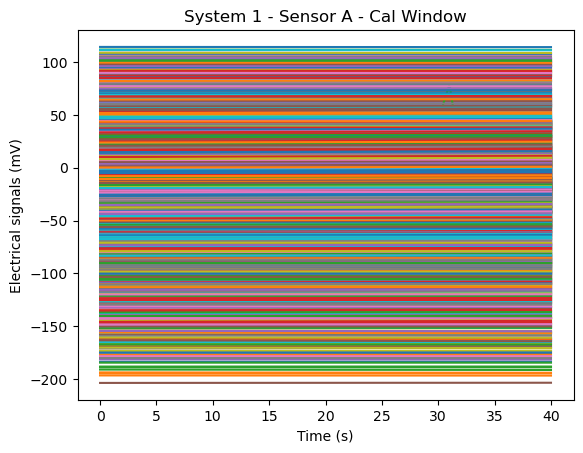

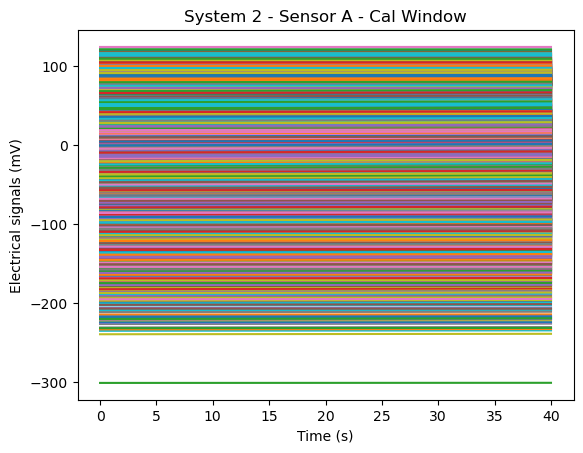

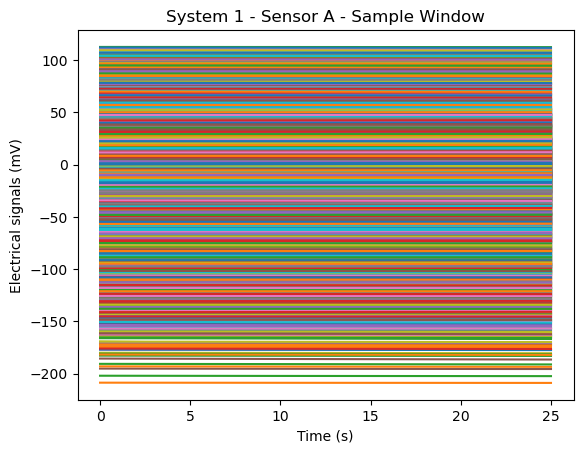

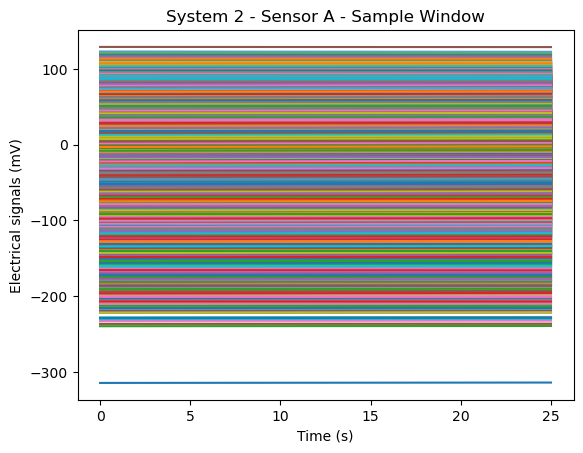

In [14]:
# A1/A2 Cal Window time series
A1_calWindow = A1_cal_window.dropna()
grid_points_A1_calWindow = A1_calWindow.columns.astype(float)
data_matrix_A1_calWindow = A1_calWindow 

fd_A1_calWindow = skfda.FDataGrid(
    data_matrix=data_matrix_A1_calWindow,
    grid_points=grid_points_A1_calWindow,
)

fd_A1_calWindow.plot()
plt.title('System 1 - Sensor A - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

A2_calWindow = A2_cal_window.dropna()
grid_points_A2_calWindow = A2_calWindow.columns.astype(float)
data_matrix_A2_calWindow = A2_calWindow 

fd_A2_calWindow = skfda.FDataGrid(
    data_matrix=data_matrix_A2_calWindow,
    grid_points=grid_points_A2_calWindow,
)

fd_A2_calWindow.plot()
plt.title('System 2 - Sensor A - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

# A1/A2 Sample Window time series
A1_sampleWindow = A1_sample_window.dropna()
grid_points_A1_sampleWindow = A1_sampleWindow.columns.astype(float)
data_matrix_A1_sampleWindow = A1_sampleWindow 

fd_A1_sampleWindow = skfda.FDataGrid(
    data_matrix=data_matrix_A1_sampleWindow,
    grid_points=grid_points_A1_sampleWindow,
)

fd_A1_sampleWindow.plot()
plt.title('System 1 - Sensor A - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

A2_sampleWindow = A2_sample_window.dropna()
grid_points_A2_sampleWindow = A2_sampleWindow.columns.astype(float)
data_matrix_A2_sampleWindow = A2_sampleWindow 

fd_A2_sampleWindow = skfda.FDataGrid(
    data_matrix=data_matrix_A2_sampleWindow,
    grid_points=grid_points_A2_sampleWindow,
)

fd_A2_sampleWindow.plot()
plt.title('System 2 - Sensor A - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

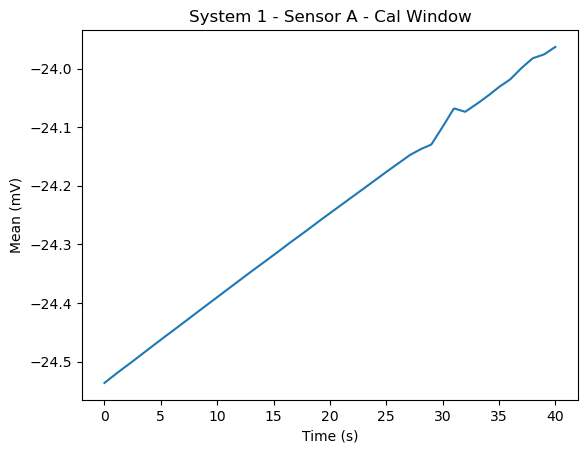

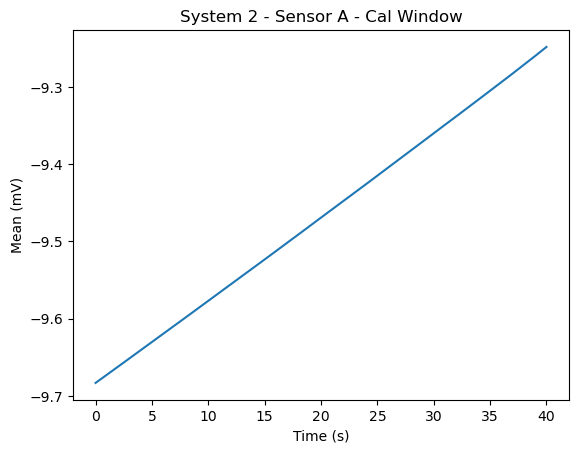

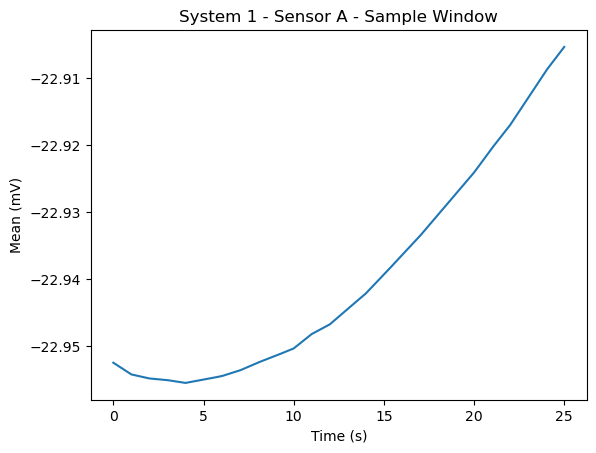

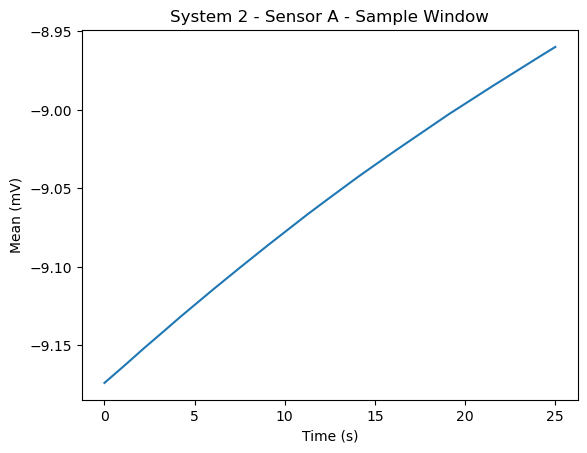

In [15]:
# Means A1/A2 Cal Window time series
means_A1_calWindow = skfda.exploratory.stats.mean(fd_A1_calWindow)
means_A1_calWindow.plot()
plt.title('System 1 - Sensor A - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

means_A2_calWindow = skfda.exploratory.stats.mean(fd_A2_calWindow)
means_A2_calWindow.plot()
plt.title('System 2 - Sensor A - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

# Means A1/A2 Sample Window time series
means_A1_sampleWindow = skfda.exploratory.stats.mean(fd_A1_sampleWindow)
means_A1_sampleWindow.plot()
plt.title('System 1 - Sensor A - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

means_A2_sampleWindow = skfda.exploratory.stats.mean(fd_A2_sampleWindow)
means_A2_sampleWindow.plot()
plt.title('System 2 - Sensor A - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

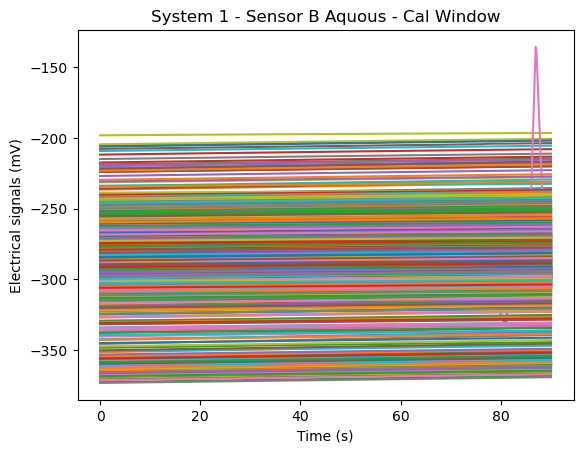

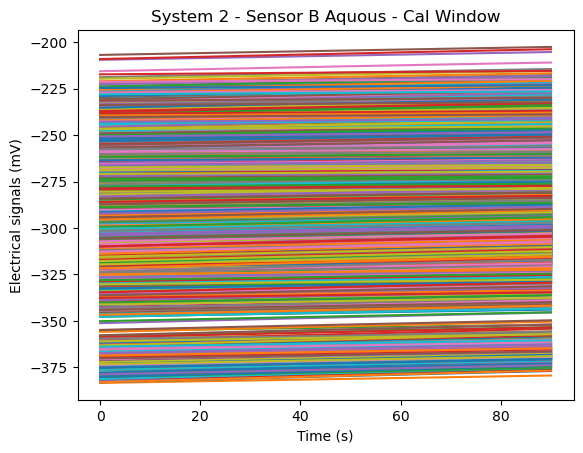

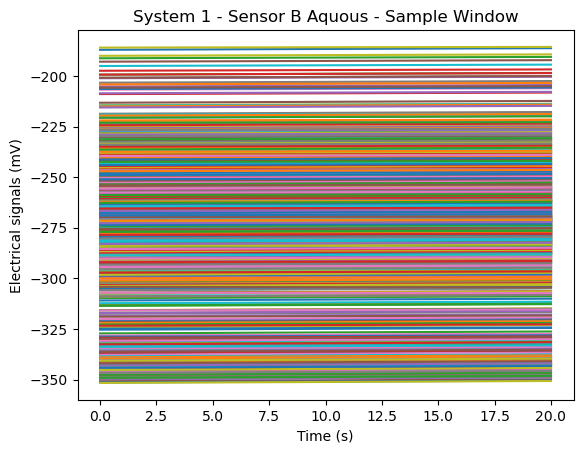

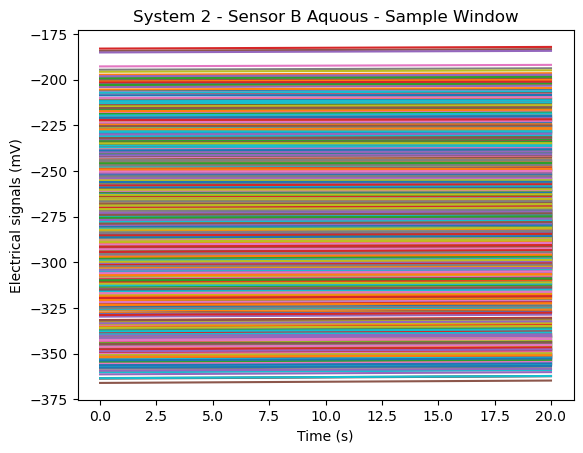

In [16]:
# Display B1/B2 - Aquous Cal Window time series
B1_aquous_calWindow = B1_aquous_cal_window.dropna()
grid_points_B1_aquous_calWindow = B1_aquous_calWindow.columns.astype(float)
data_matrix_B1_aquous_calWindow = B1_aquous_calWindow

fd_B1_aquous_calWindow = skfda.FDataGrid(
    data_matrix=data_matrix_B1_aquous_calWindow,
    grid_points=grid_points_B1_aquous_calWindow,
)

fd_B1_aquous_calWindow.plot()
plt.title('System 1 - Sensor B Aquous - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

B2_aquous_calWindow = B2_aquous_cal_window.dropna()
grid_points_B2_aquous_calWindow = B2_aquous_calWindow.columns.astype(float)
data_matrix_B2_aquous_calWindow = B2_aquous_calWindow

fd_B2_aquous_calWindow = skfda.FDataGrid(
    data_matrix=data_matrix_B2_aquous_calWindow,
    grid_points=grid_points_B2_aquous_calWindow,
)

fd_B2_aquous_calWindow.plot()
plt.title('System 2 - Sensor B Aquous - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

# Display B1/B2 - Aquous Sample Window time series
B1_aquous_sampleWindow = B1_aquous_sample_window.dropna()
grid_points_B1_aquous_sampleWindow = B1_aquous_sampleWindow.columns.astype(float)
data_matrix_B1_aquous_sampleWindow = B1_aquous_sampleWindow

fd_B1_aquous_sampleWindow = skfda.FDataGrid(
    data_matrix=data_matrix_B1_aquous_sampleWindow,
    grid_points=grid_points_B1_aquous_sampleWindow,
)

fd_B1_aquous_sampleWindow.plot()
plt.title('System 1 - Sensor B Aquous - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

B2_aquous_sampleWindow = B2_aquous_sample_window.dropna()
grid_points_B2_aquous_sampleWindow = B2_aquous_sampleWindow.columns.astype(float)
data_matrix_B2_aquous_sampleWindow = B2_aquous_sampleWindow

fd_B2_aquous_sampleWindow = skfda.FDataGrid(
    data_matrix=data_matrix_B2_aquous_sampleWindow,
    grid_points=grid_points_B2_aquous_sampleWindow,
)

fd_B2_aquous_sampleWindow.plot()
plt.title('System 2 - Sensor B Aquous - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

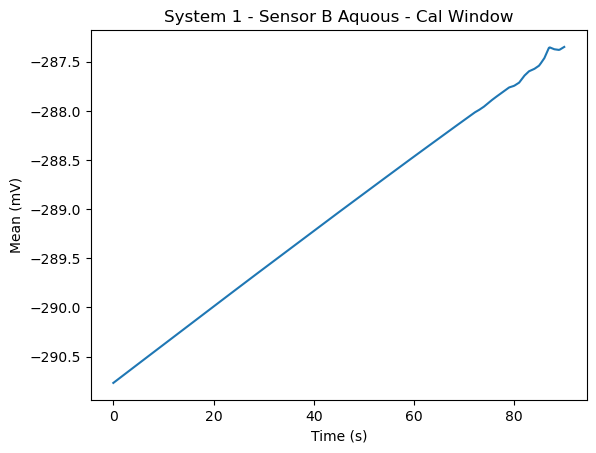

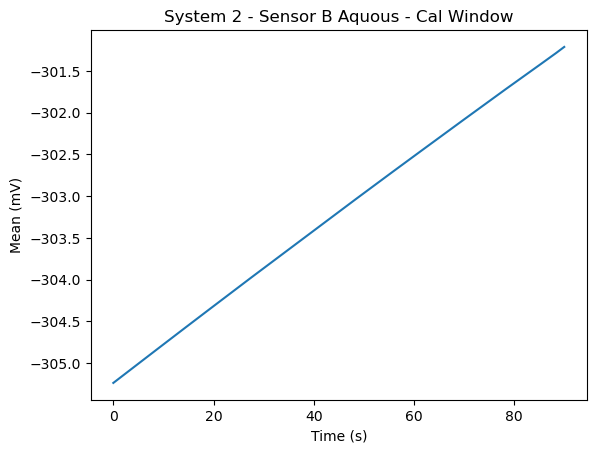

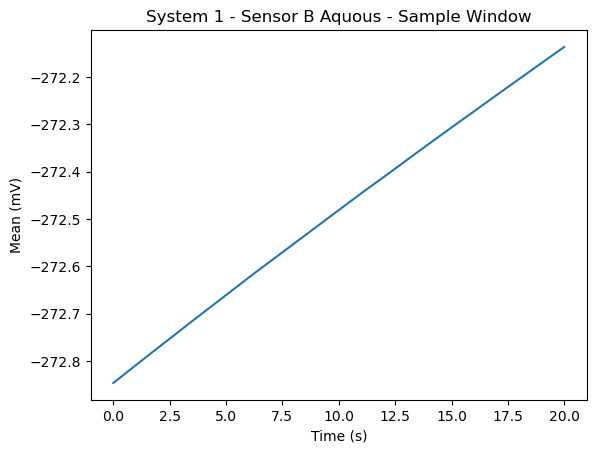

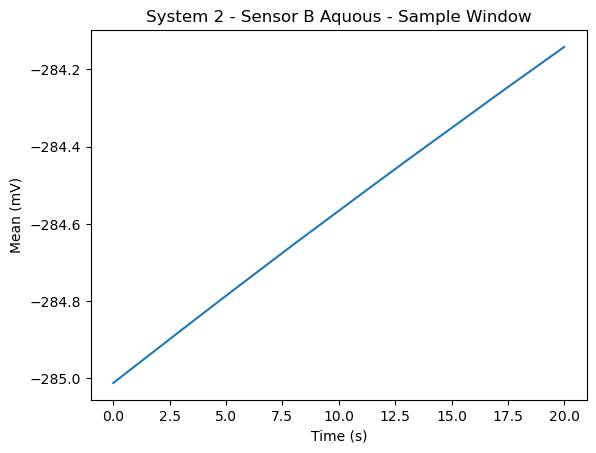

In [17]:
# Means B1/B2 Aquous Cal Window time series
means_B1_aquous_calWindow = skfda.exploratory.stats.mean(fd_B1_aquous_calWindow)
means_B1_aquous_calWindow.plot()
plt.title('System 1 - Sensor B Aquous - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

means_B2_aquous_calWindow = skfda.exploratory.stats.mean(fd_B2_aquous_calWindow)
means_B2_aquous_calWindow.plot()
plt.title('System 2 - Sensor B Aquous - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

# Means B1/B2 Aquous Sample Window time series
means_B1_aquous_sampleWindow = skfda.exploratory.stats.mean(fd_B1_aquous_sampleWindow)
means_B1_aquous_sampleWindow.plot()
plt.title('System 1 - Sensor B Aquous - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

means_B2_aquous_sampleWindow = skfda.exploratory.stats.mean(fd_B2_aquous_sampleWindow)
means_B2_aquous_sampleWindow.plot()
plt.title('System 2 - Sensor B Aquous - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

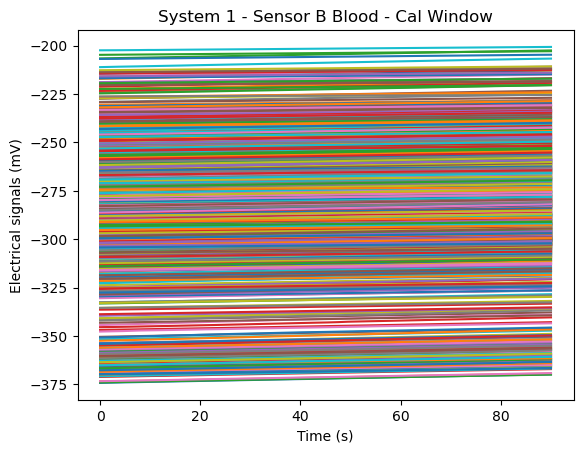

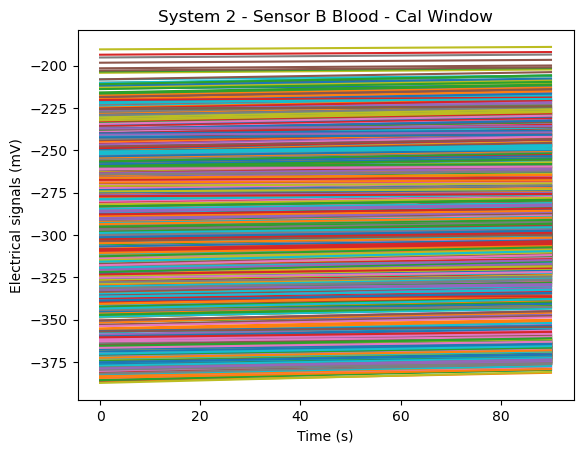

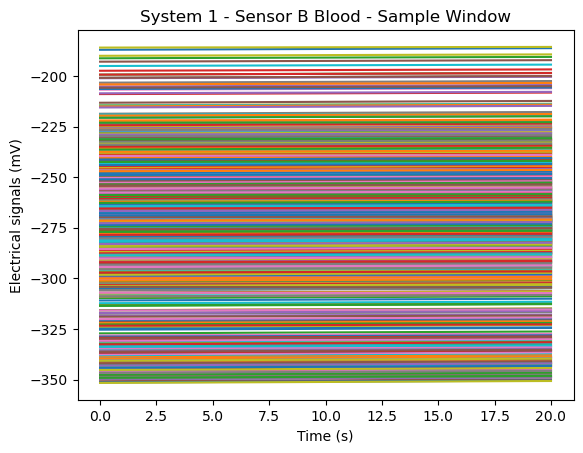

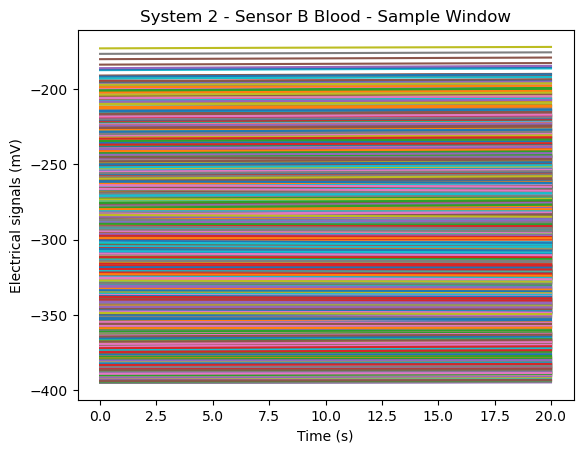

In [18]:
# Display B1/B2 - Blood Cal Window time series
B1_blood_calWindow = B1_blood_cal_window.dropna()
grid_points_B1_blood_calWindow = B1_blood_calWindow.columns.astype(float)
data_matrix_B1_blood_calWindow = B1_blood_calWindow

fd_B1_blood_calWindow = skfda.FDataGrid(
    data_matrix=data_matrix_B1_blood_calWindow,
    grid_points=grid_points_B1_blood_calWindow,
)

fd_B1_blood_calWindow.plot()
plt.title('System 1 - Sensor B Blood - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

B2_blood_calWindow = B2_blood_cal_window.dropna()
grid_points_B2_blood_calWindow = B2_blood_calWindow.columns.astype(float)
data_matrix_B2_blood_calWindow = B2_blood_calWindow

fd_B2_blood_calWindow = skfda.FDataGrid(
    data_matrix=data_matrix_B2_blood_calWindow,
    grid_points=grid_points_B2_blood_calWindow,
)

fd_B2_blood_calWindow.plot()
plt.title('System 2 - Sensor B Blood - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

# Display B1/B2 - Blood Sample Window time series
B1_blood_sampleWindow = B1_aquous_sample_window.dropna()
grid_points_B1_blood_sampleWindow = B1_blood_sampleWindow.columns.astype(float)
data_matrix_B1_blood_sampleWindow = B1_blood_sampleWindow

fd_B1_blood_sampleWindow = skfda.FDataGrid(
    data_matrix=data_matrix_B1_blood_sampleWindow,
    grid_points=grid_points_B1_blood_sampleWindow,
)

fd_B1_blood_sampleWindow.plot()
plt.title('System 1 - Sensor B Blood - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

B2_blood_sampleWindow = B2_blood_sample_window.dropna()
grid_points_B2_blood_sampleWindow = B2_blood_sampleWindow.columns.astype(float)
data_matrix_B2_blood_sampleWindow = B2_blood_sampleWindow

fd_B2_blood_sampleWindow = skfda.FDataGrid(
    data_matrix=data_matrix_B2_blood_sampleWindow,
    grid_points=grid_points_B2_blood_sampleWindow,
)

fd_B2_blood_sampleWindow.plot()
plt.title('System 2 - Sensor B Blood - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Electrical signals (mV)')
plt.show()

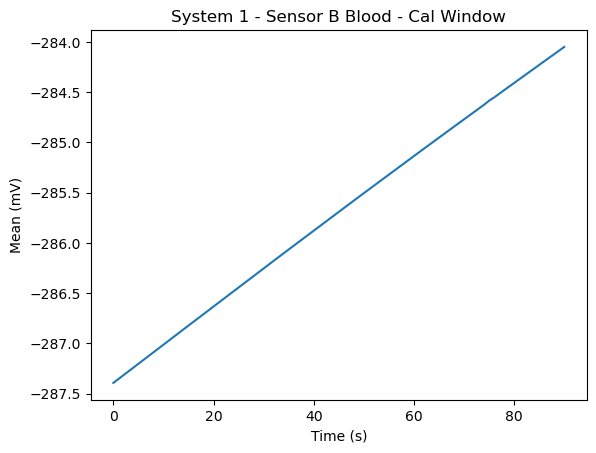

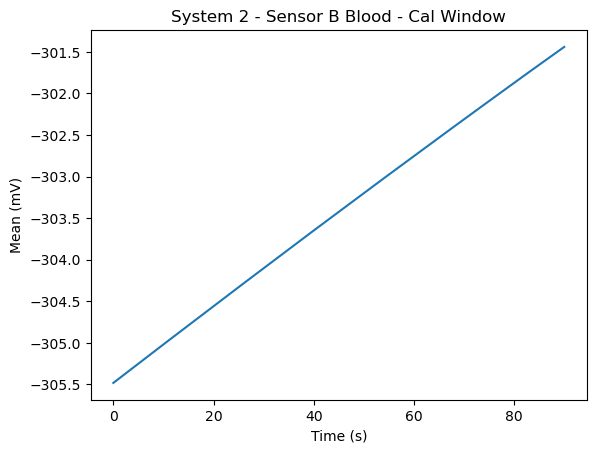

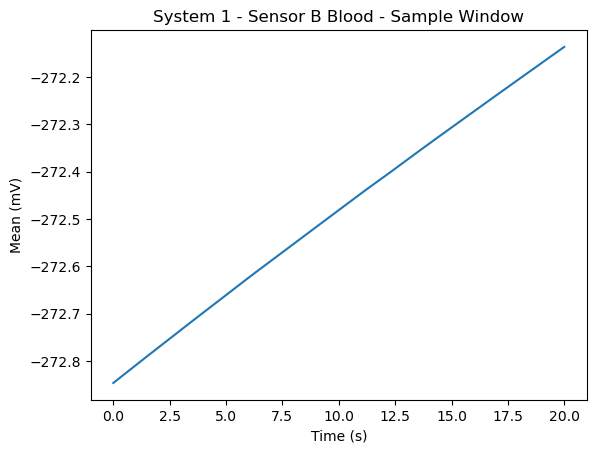

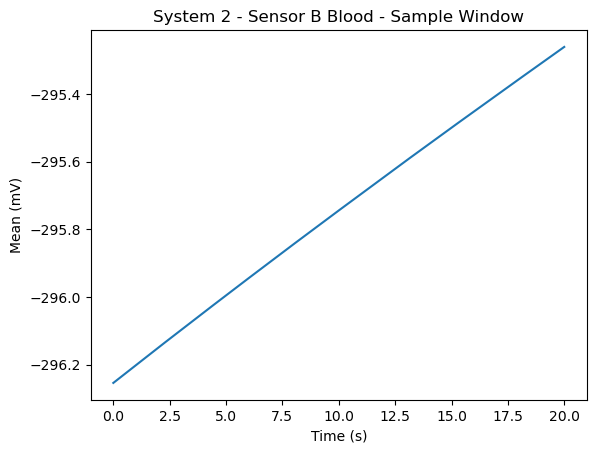

In [19]:
# Means B1/B2 Blood Cal Window time series
means_B1_blood_calWindow = skfda.exploratory.stats.mean(fd_B1_blood_calWindow)
means_B1_blood_calWindow.plot()
plt.title('System 1 - Sensor B Blood - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

means_B2_aquous_calWindow = skfda.exploratory.stats.mean(fd_B2_blood_calWindow)
means_B2_aquous_calWindow.plot()
plt.title('System 2 - Sensor B Blood - Cal Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

# Means B1/B2 Blood Sample Window time series
means_B1_blood_sampleWindow = skfda.exploratory.stats.mean(fd_B1_blood_sampleWindow)
means_B1_blood_sampleWindow.plot()
plt.title('System 1 - Sensor B Blood - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()

means_B2_blood_sampleWindow = skfda.exploratory.stats.mean(fd_B2_blood_sampleWindow)
means_B2_blood_sampleWindow.plot()
plt.title('System 2 - Sensor B Blood - Sample Window')
plt.xlabel('Time (s)')
plt.ylabel('Mean (mV)')
plt.show()